In [1]:
import torch
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
from argparse import Namespace

from torch import nn
from dataloader import load_data
from tqdm import tqdm


train_inputs,train_lables,test_inputs,test_lables=load_data(60000,60000,device=torch.device('cuda:5'))




load data set
create loader
construct data


100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


/tmp/ipykernel_1527498/851210931.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp = torch.load('./mlp.pth')
/tmp/ipykernel_1527498/851210931.py:80: FutureWarning: Yo

15
0.9213
0.8729
0.8449
0.848
0.8482
0.8406
0.7643
0.7745
0.561
0.5538
0.4725
0.5875
0.5178
0.5394
0.5876
0.4964
0.3994
0.3846
0.2175
0.1663
0.1682
0.196
0.1073
0.2171
0.2314
0.1736
0.1321
0.1291
0.1389
0.1537
0.0968
0.0953
0.0874
0.0816
0.1331
0.0956
0.139
0.132
0.1041
0.0422
0.1115
0.1634
0.1051
0.1038
0.1032
0.1032
0.1032
0.1032
0.1032
0.1032


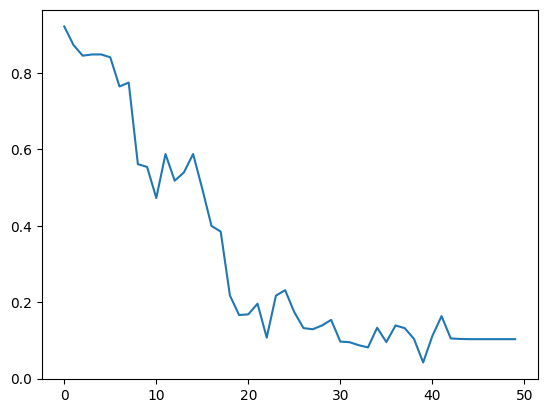

In [41]:
import torch
import model
# from model import Bias
from torch import nn
import importlib
# importlib.reload(model)


def acc(model):
    model.eval()
    correct=0
    total=0
    with torch.no_grad():
        
        for i in range(len(test_inputs)):
            outputs=model(test_inputs[i])
            _,predicted=torch.max(outputs.data,1)
            total+=len(predicted)
            correct+=(predicted==test_lables[i]).sum().item()
    model.train()
    return correct/total


mlp = torch.load('./mlp.pth')
print(len(mlp.layers))
device=next(mlp.parameters()).device

def svd(reduce):
    for k,layer in enumerate(mlp.layers):
        if (isinstance(layer, torch.nn.Linear)):
            w=layer.weight
            b=layer.bias
            U,S,V=torch.linalg.svd(w)
            # print(U)



            nU=U.shape[0]
            mU=U.shape[1]
            nV=V.shape[0]
            mV=V.shape[1]
            nS=mU
            mS=nV

            r=int(min(nU,nV)*reduce)
            U=U[:,:r]
            mU=r
            V=V[:r,]
            nV=r

            S_diag = torch.zeros(nS,mS)
            for i in range(S.shape[0]):
                S_diag[i, i] = S[i]
            S=S_diag

            S=S[:r,:r]
            nS=r
            mS=r


            newlinear1=torch.nn.Linear(nU,mU,bias=False).to(device)
            newlinear2=torch.nn.Linear(nS,mS,bias=False).to(device)
            newlinear3=torch.nn.Linear(nV,mV,bias=False).to(device)
            newlinear1.weight=nn.Parameter(U)
            newlinear2.weight=nn.Parameter(S)
            newlinear3.weight=nn.Parameter(V)
            newbias=model.Bias(b)
            newbias=newbias.to(device)
            # print(newlinear1.weight.shape)
            # print(newlinear2.weight.shape)
            # print(newlinear3.weight.shape)
            # print('------------')
            svded=nn.Sequential(newlinear3,newlinear2,newlinear1,newbias)
            mlp.layers[k]=svded

from matplotlib import pylab as plt
y=[]
import numpy as np
for i in np.arange(1, 0, -0.02):
    mlp = torch.load('./mlp.pth')
    svd(i)
    mlp.eval()
    mlp.to(device)
    for layer in mlp.layers:
        if(isinstance(layer,torch.nn.Sequential)):
            for sublayer in layer:
                sublayer.to(device)
                if(not isinstance(sublayer,nn.Module)):
                    print(sublayer.weight.shape)
        # print('----------------')

    print(acc(mlp))
    y.append(acc(mlp))

plt.plot(y)
plt.show()
